In [1]:
import torch
from torch.nn import functional as F
from gpt_class import GPTConfig, GPT
import tiktoken

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

state_dict = torch.load('log/model_51999.pt')
config = state_dict['config']
model = GPT(config)
model.to(device)
model.load_state_dict(state_dict['model'])

model.eval()
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [2]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(256, 768)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [3]:
# Initialize TikToken tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
# tokenizer.get_encoding("gpt2") 

In [4]:
def generate_text(prompt, model, tokenizer, max_length=50):
    # Encode the input prompt
    input_ids = tokenizer.encode(prompt)
    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)

    # Generate output from the model
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs[0]  # Assuming the logits are the first item in the tuple

    # Assuming the model outputs logits; take the argmax to get token IDs
    predictions = torch.argmax(F.log_softmax(logits, dim=-1), dim=-1)

    # Decode the output
    generated_text = tokenizer.decode(predictions[0].tolist())
    return generated_text


In [5]:
prompt = "This is all about"
generated_text = generate_text(prompt, model, tokenizer)
print("Generated Text:", generated_text)


Generated Text:  is a very the


In [6]:
import torch
from torch.nn import functional as F
# from ddp import is_ddp

# def Generate(model ,tokenizer , example = "this is all about ", num_return_sequences=4, max_length=32):
def Generate(model ,tokenizer , example, num_return_sequences, max_length):
    enc = tokenizer
    # ddp, ddp_rank, ddp_local_rank, ddp_world_size, master_process, device = "cuda"
    device_type = "cuda" if device.startswith("cuda") else "cpu"
    # device_type = "cpu"
    model.eval()
    num_return_sequences = num_return_sequences
    max_length = max_length
    tokens = enc.encode(example)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    
    
    xgen = tokens.to(device)
    sample_rng = torch.Generator(device=device)
    while xgen.size(1) < max_length:
        # forward the model to get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, loss = model(xgen) # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)
        # print the generated text
    for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            # print(f"rank {ddp_rank} sample {i}: {decoded}")
            
            
            with open('./generation.txt', "a", encoding="utf-8") as f:
                f.write(f"rank  sample {i}: {decoded} \n")
    print("Written to file")

In [7]:
Generate(model ,tokenizer , example = "as we entered the forest, we saw", num_return_sequences=4, max_length=64)


Written to file


Min Train Loss: 2.883471
Min Validation Loss: 3.1989
Max Hellaswag eval: 0.3054


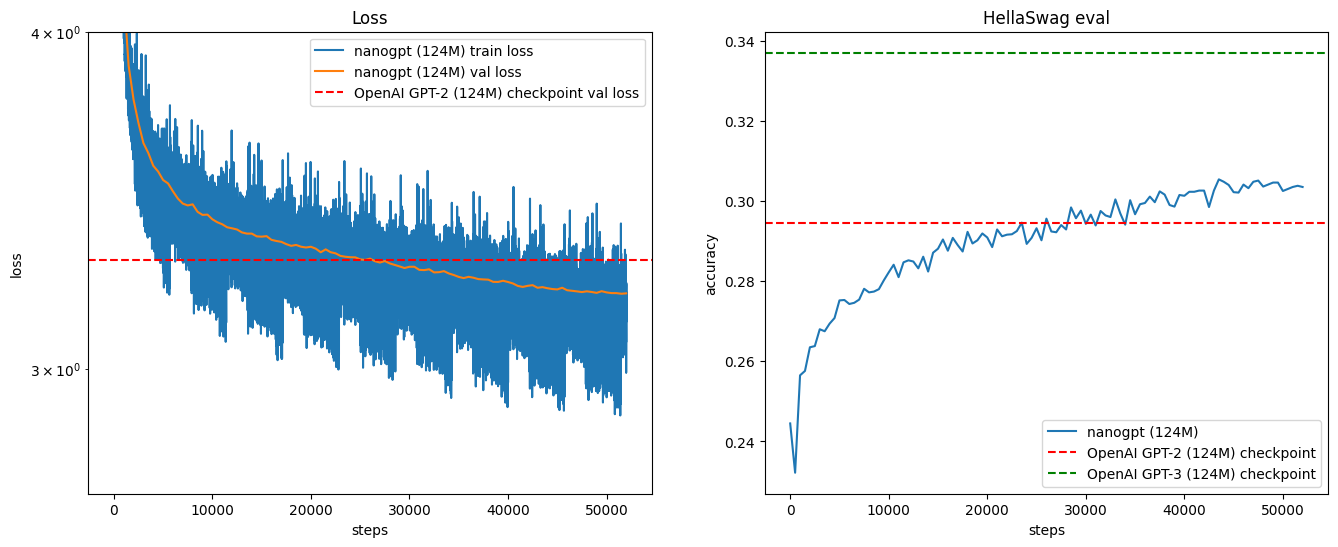

In [8]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("/home/iitgn_cse/Aamod_exp/log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))